In [31]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

In [28]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    
    #Define different arrays and initialize y_min and y_max
    right_slope=[]
    right_x=[]
    right_y=[]
    left_slope=[]
    left_x=[]
    left_y=[]
    y_min=320
    y_max=img.shape[0]
    
    #Calculate slope and assign them to left/right side
    for line in lines:
        for x1,y1,x2,y2 in line:
            #identify global minimum y
            if y1<y_min:
                y_min=y1
            #Calculate slope and assign it likewise
            slope= (y2-y1)/(x2-x1)

            if -0.8 < slope < -0.4:# Right lane, negative slope
                right_slope.append(slope)
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
            elif 0.8 > slope > 0.4: # Left lane, positive slope
                left_slope.append(slope)
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)    

    #Averaging the position of line segment right side
    avg_right_slope= sum(right_slope)/float(len(right_slope))
    avg_right_x=sum(right_x)/float(len(right_x))
    avg_right_y=sum(right_y)/float(len(right_y))
    #Calculate intercept for averaged right coordinates
    right_intercept= avg_right_y-(avg_right_slope*avg_right_x)
    #Find x1,x2 for highest point, we already have y1,y2
    x1_right=(y_min-right_intercept)/avg_right_slope
    x2_right=(y_max-right_intercept)/avg_right_slope
    #Draw right line
    cv2.line(img, (int(x1_right), y_min), (int(x2_right), y_max), color, thickness)
    
    #Averaging the position of line segment left side
    avg_left_slope= sum(left_slope)/float(len(left_slope))
    avg_left_x=sum(left_x)/float(len(left_x))
    avg_left_y=sum(left_y)/float(len(left_y))
    #Calculate intercept for averaged left coordinates
    left_intercept= avg_left_y-(avg_left_slope*avg_left_x)
    #Find x1,x2 for highest point, we already have y1,y2
    x1_left=(y_min-left_intercept)/avg_left_slope
    x2_left=(y_max-left_intercept)/avg_left_slope
    #Draw left line
    cv2.line(img, (int(x1_left), y_min), (int(x2_left), y_max), color, thickness)

In [29]:

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


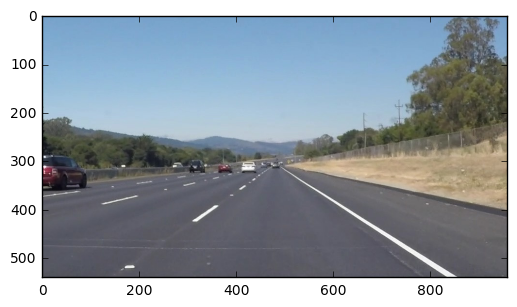

In [272]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [19]:
#plt.imshow(gray, cmap='gray')
#plt.imshow(blur_gray, cmap='gray')
#plt.imshow(edges, cmap='gray')

In [20]:
#print('dim',image.shape)
#print('canny edges',edges)

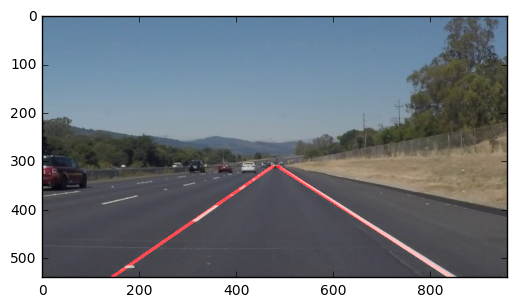

In [34]:
gray=grayscale(image)
blur_gray =gaussian_blur(gray,3)
edges=canny(blur_gray,75,150)
masked_edges=region_of_interest(edges,np.array([[(150,540),(450,320),(490,310),(900,540)]]))
img=hough_lines(masked_edges,2,np.pi/180,15,40,20)
final_no_extrapol=weighted_img(img,image)
plt.imshow(final_no_extrapol)

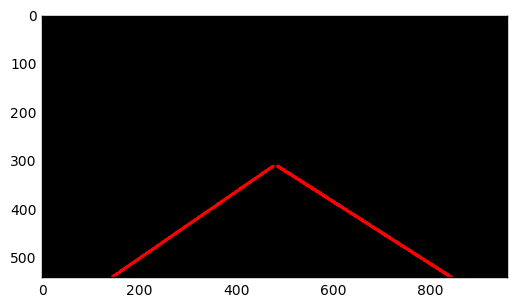

In [42]:
plt.imshow(line_image)

classify left and right lanes
then extrapolate

In [301]:
def process_test_image(image):
    for i in range(len(image)):
        img = (mpimg.imread("test_images/"+image[i])) #original image
        gray=grayscale(img)
        blur_gray =gaussian_blur(gray,3)
        edges=canny(blur_gray,75,150)
        masked_edges=region_of_interest(edges,np.array([[(150,540),(450,320),(490,310),(900,540)]]))
        h_img=hough_lines(masked_edges,2,np.pi/180,15,40,20)
        final=weighted_img(h_img,img)
        plt.imshow(final)
        plt.show()
    #return final   

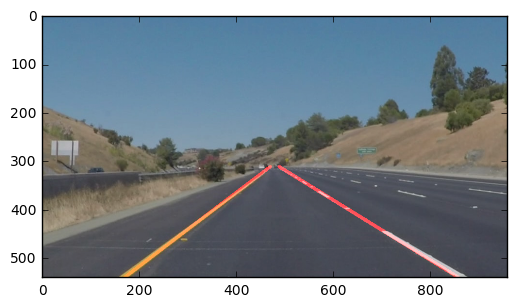

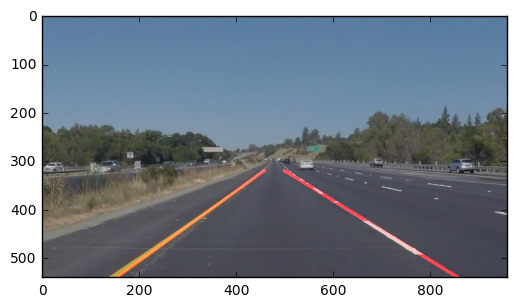

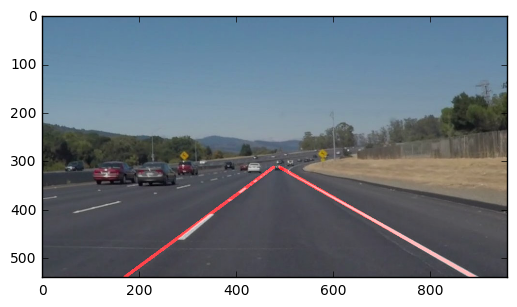

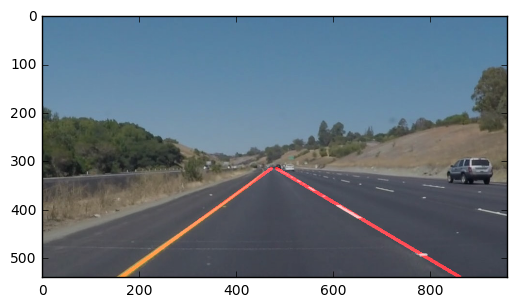

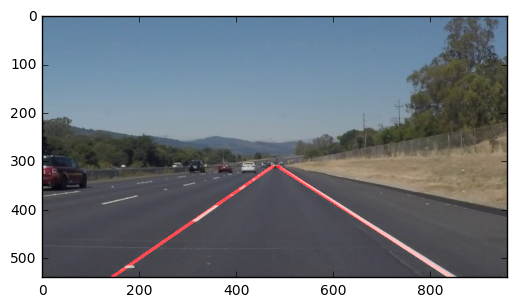

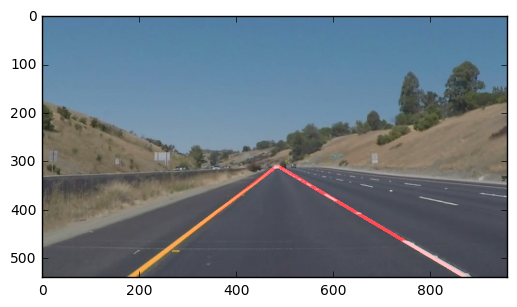

In [302]:
import os
images=os.listdir("test_images/")
process_test_image(images)

##MOVIE

http://zulko.github.io/moviepy/examples/quick_recipes.html?highlight=fl_image

https://github.com/Zulko/moviepy/issues/159

http://zulko.github.io/moviepy/getting_started/effects.html


In [296]:
def process_image(image):
    gray=grayscale(image)
    blur_gray =gaussian_blur(gray,3)
    edges=canny(blur_gray,75,150)
    masked_edges=region_of_interest(edges,np.array([[(150,540),(450,320),(490,310),(900,540)]]))
    h_img=hough_lines(masked_edges,2,np.pi/180,15,40,20)
    final=weighted_img(h_img,image)
    return final   

In [285]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [286]:
from moviepy.editor import *
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
#IPython.display(clip1)

In [289]:
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:08<00:00, 25.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 55.8 s, sys: 2.34 s, total: 58.1 s
Wall time: 9.24 s


In [264]:
#def invert_green_blue(image):
#    return image[:,:,[0,2,1]]

In [293]:
#modifiedClip = clip1.fl_image( invert_green_blue )
#%time modifiedClip.write_videofile(white_output, audio=False)

In [298]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [300]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



  4%|▍         | 26/682 [00:00<00:13, 48.25it/s]

ZeroDivisionError: float division by zero


  4%|▍         | 26/682 [00:12<05:26,  2.01it/s]